This notebook present the steps to generate merged catalog files. The reason that we need to generate such files is that:

1. Bliss needs input parameters that contains psf, fluxes, location, source type, galaxy related parameters, but the truth catalog in DC2 does not provide galaxy parameters or psf
2. To get those parameter, we need to use CosmoDC2 dataset and truth-match table, where the galaxy parameters and psf are stored.
3. To save the time for multiple merging when loading the data, we store the merged dataset into corresponding merged_catalog_{}.pkl files

### Load Catalog

Use [GCRCatalogs](https://data.lsstdesc.org/doc/install_gcr) package to load the dc2 truth catalog and CosomoDC2.




In [1]:
import pickle
import GCRCatalogs
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
from pathlib import Path
import pandas as pd

from GCRCatalogs import GCRQuery

In [2]:
output_dir = Path("./generate_new_catalog_output/")
output_dir.mkdir(parents=True, exist_ok=True)

In [3]:
ori_cat = pd.read_pickle("/data/scratch/dc2local/old_dc2_catalog/ori_merged_catalog_with_flux_over_50.pkl")

In [4]:
ori_max_ra = ori_cat["ra"].max()
ori_min_ra = ori_cat["ra"].min()
ori_max_dec = ori_cat["dec"].max()
ori_min_dec = ori_cat["dec"].min()
ra_dec_filters = [f"ra >= {ori_min_ra - 0.1}", f"ra <= {ori_max_ra + 0.1}", 
                  f"dec >= {ori_min_dec - 0.1}", f"dec <= {ori_max_dec + 0.1}"]

In [5]:
GCRCatalogs.set_root_dir("/data/scratch/dc2_nfs/")

In [6]:
truth_catalog_pickle_file = output_dir / "truth_catalog.pkl"
if truth_catalog_pickle_file.exists():
    with open(truth_catalog_pickle_file, "rb") as inputp: 
        truth_cat_data = pickle.load(inputp)
else:   
    truth_cat = GCRCatalogs.load_catalog("desc_dc2_run2.2i_dr6_truth") 
    print(sorted(truth_cat.list_all_quantities()))
    truth_cat_data = truth_cat.get_quantities([
        "id", "match_objectId", "cosmodc2_id", 
        "ra", "dec", 
        "truth_type", 
        "flux_g", "flux_i", "flux_r", "flux_u", "flux_y", "flux_z",
        "redshift",
    ],
    filters=ra_dec_filters)
    # with open(truth_catalog_pickle_file, "wb") as outp:
    #     pickle.dump(truth_cat_data, outp, pickle.HIGHEST_PROTOCOL)

truth_cat_df = pd.DataFrame(truth_cat_data)
truth_cat_df.rename(columns={"redshift": "redshifts"}, inplace=True)

['av', 'cosmodc2_hp', 'cosmodc2_id', 'dec', 'flux_g', 'flux_i', 'flux_r', 'flux_u', 'flux_y', 'flux_z', 'host_galaxy', 'id', 'id_string', 'is_good_match', 'is_nearest_neighbor', 'is_unique_truth_entry', 'mag_g', 'mag_i', 'mag_r', 'mag_u', 'mag_y', 'mag_z', 'match_objectId', 'match_sep', 'patch', 'ra', 'redshift', 'rv', 'tract', 'truth_type']


In [7]:
print(len(truth_cat_df))

60489715


In [8]:
print(1 - (truth_cat_df["flux_r"] > 100).values.sum() / len(truth_cat_df))

0.8513013658602955


In [9]:
print(truth_cat_df["ra"].min(), truth_cat_df["ra"].max())
print(truth_cat_df["dec"].min(), truth_cat_df["dec"].max())

53.80862966850614 61.31827339504263
-38.77768590235156 -34.11487648533201


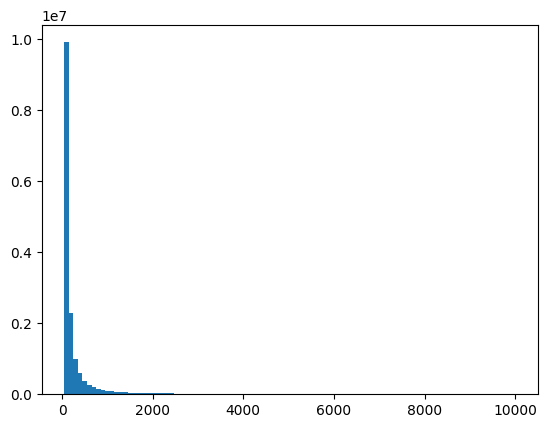

In [10]:
plt.hist(truth_cat_data["flux_r"], np.linspace(50, 10000, num=100))
plt.show()

In [11]:
vertices = hp.ang2vec(np.array([ori_min_ra, ori_max_ra, ori_max_ra, ori_min_ra]),
                      np.array([ori_min_dec, ori_min_dec, ori_max_dec, ori_max_dec]), lonlat=True)
ipix = hp.query_polygon(32, vertices, inclusive=True)
healpix_filter = GCRQuery((lambda h: np.isin(h, ipix, True), "healpix_pixel"))

In [12]:
cosmodc2_pickle_file = output_dir / "cosmodc2.pkl"
if cosmodc2_pickle_file.exists():
    with open(cosmodc2_pickle_file, "rb") as inputp: 
        cosmodc2_data = pickle.load(inputp)
else:
    config_overwrite = dict(
        catalog_root_dir="/data/scratch/dc2_nfs/cosmoDC2_v1.1.4/"
    )
    cosmodc2_table = GCRCatalogs.load_catalog("desc_cosmodc2", config_overwrite)
    print(sorted(cosmodc2_table.list_all_quantities()))
    cosmodc2_data = cosmodc2_table.get_quantities([
        "galaxy_id",
        "shear_1", "shear_2",
        "ellipticity_1_true_dc2", "ellipticity_2_true_dc2",
        "size_true", "size_minor_true", "position_angle_true_dc2",
    ],
    native_filters=healpix_filter)
    # with open(cosmodc2_pickle_file, "wb") as outp:
    #     pickle.dump(cosmodc2_data, outp, pickle.HIGHEST_PROTOCOL)

cosmodc2_df = pd.DataFrame(cosmodc2_data).rename(columns={
    "ellipticity_1_true_dc2": "ellipticity_1_true",
    "ellipticity_2_true_dc2": "ellipticity_2_true",
})

['A_v', 'A_v_bulge', 'A_v_disk', 'Mag_true_Y_lsst_z0', 'Mag_true_Y_lsst_z0_no_host_extinction', 'Mag_true_g_lsst_z0', 'Mag_true_g_lsst_z0_no_host_extinction', 'Mag_true_g_sdss_z0', 'Mag_true_g_sdss_z0_no_host_extinction', 'Mag_true_i_lsst_z0', 'Mag_true_i_lsst_z0_no_host_extinction', 'Mag_true_i_sdss_z0', 'Mag_true_i_sdss_z0_no_host_extinction', 'Mag_true_r_lsst_z0', 'Mag_true_r_lsst_z0_no_host_extinction', 'Mag_true_r_sdss_z0', 'Mag_true_r_sdss_z0_no_host_extinction', 'Mag_true_u_lsst_z0', 'Mag_true_u_lsst_z0_no_host_extinction', 'Mag_true_u_sdss_z0', 'Mag_true_u_sdss_z0_no_host_extinction', 'Mag_true_y_lsst_z0', 'Mag_true_y_lsst_z0_no_host_extinction', 'Mag_true_z_lsst_z0', 'Mag_true_z_lsst_z0_no_host_extinction', 'Mag_true_z_sdss_z0', 'Mag_true_z_sdss_z0_no_host_extinction', 'R_v', 'R_v_bulge', 'R_v_disk', 'bulge_to_total_ratio_i', 'convergence', 'dec', 'dec_true', 'ellipticity_1_bulge_true', 'ellipticity_1_bulge_true_dc2', 'ellipticity_1_disk_true', 'ellipticity_1_disk_true_dc2', '

In [13]:
print(len(cosmodc2_df))

327021149


In [14]:
print(np.isnan(cosmodc2_df["shear_1"].values).sum() / len(cosmodc2_df))

0.0


In [15]:
cosmodc2_df["shear_1"].describe()

count    3.270211e+08
mean    -2.898190e-03
std      1.803715e-02
min     -1.842399e-01
25%     -1.308544e-02
50%     -2.366003e-03
75%      7.341075e-03
max      1.913079e-01
Name: shear_1, dtype: float64

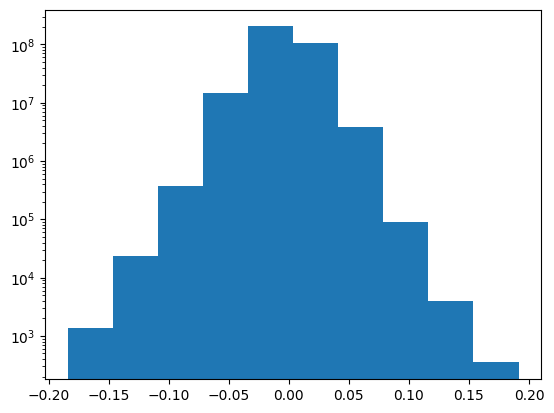

In [16]:
plt.hist(cosmodc2_df["shear_1"], log=True)
plt.show()

In [17]:
print(np.isnan(cosmodc2_df["shear_2"].values).sum() / len(cosmodc2_df))

0.0


In [18]:
cosmodc2_df["shear_2"].describe()

count    3.270211e+08
mean     9.801464e-04
std      1.768306e-02
min     -1.952726e-01
25%     -8.940905e-03
50%      8.083878e-04
75%      1.087075e-02
max      1.886922e-01
Name: shear_2, dtype: float64

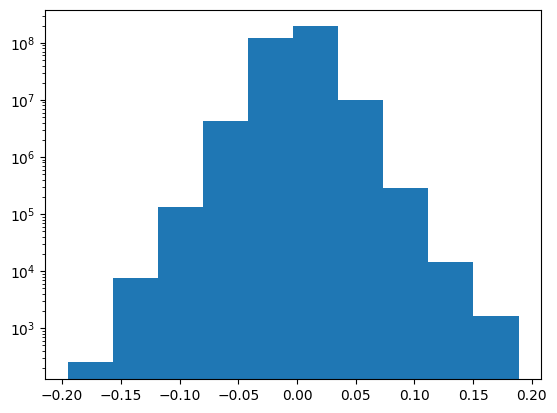

In [19]:
plt.hist(cosmodc2_df["shear_2"], log=True)
plt.show()

In [20]:
print(np.isnan(cosmodc2_df["ellipticity_1_true"].values).sum() / len(cosmodc2_df))

0.0


In [21]:
cosmodc2_df["ellipticity_1_true"].describe()

count    3.270211e+08
mean     2.209228e-05
std      1.571114e-01
min     -9.466370e-01
25%     -3.809191e-02
50%      4.056555e-06
75%      3.816555e-02
max      9.469931e-01
Name: ellipticity_1_true, dtype: float64

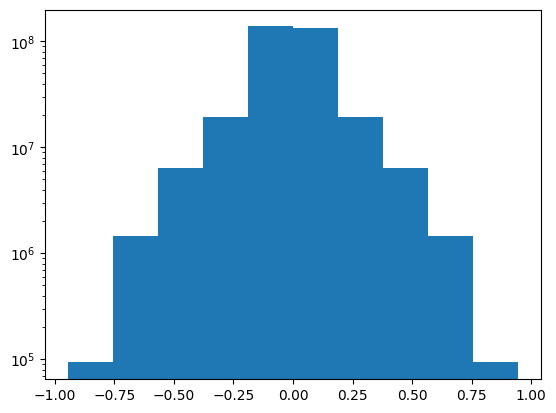

In [22]:
plt.hist(cosmodc2_df["ellipticity_1_true"], log=True)
plt.show()

In [23]:
print(np.isnan(cosmodc2_df["ellipticity_2_true"].values).sum() / len(cosmodc2_df))

0.0


In [24]:
cosmodc2_df["ellipticity_2_true"].describe()

count    3.270211e+08
mean     2.309469e-05
std      1.570970e-01
min     -9.421196e-01
25%     -3.811230e-02
50%     -2.388900e-07
75%      3.814654e-02
max      9.429858e-01
Name: ellipticity_2_true, dtype: float64

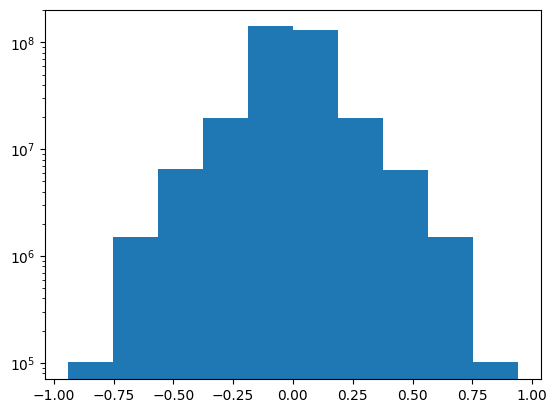

In [25]:
plt.hist(cosmodc2_df["ellipticity_2_true"], log=True)
plt.show()

In [26]:
print(np.isnan(cosmodc2_df["size_true"].values).sum() / len(cosmodc2_df))

0.0


In [27]:
truth_match_pickle_file = output_dir / "psf_params.pkl"
if truth_match_pickle_file.exists():
    with open(truth_match_pickle_file, "rb") as inputp: 
        truth_match_data = pickle.load(inputp)
else:
    truth_match = GCRCatalogs.load_catalog("desc_dc2_run2.2i_dr6_object_with_truth_match")
    print(sorted(truth_match.list_all_quantities()))
    truth_match_data = truth_match.get_quantities([
        "objectId",
        "blendedness",
        "is_good_match", "is_nearest_neighbor", "is_unique_truth_entry",
        "Ixx_pixel", "Iyy_pixel", "Ixy_pixel",
        "IxxPSF_pixel_g", "IxxPSF_pixel_z", 
        "IxxPSF_pixel_r", "IxxPSF_pixel_i", "IxxPSF_pixel_u", 
        "IxxPSF_pixel_y", "IyyPSF_pixel_g", "IyyPSF_pixel_z", 
        "IyyPSF_pixel_r", "IyyPSF_pixel_i", "IyyPSF_pixel_u", 
        "IyyPSF_pixel_y", "IxyPSF_pixel_g", "IxyPSF_pixel_z", 
        "IxyPSF_pixel_r", "IxyPSF_pixel_i", "IxyPSF_pixel_u", 
        "IxyPSF_pixel_y", "psf_fwhm_g", "psf_fwhm_z", "psf_fwhm_r",
        "psf_fwhm_i", "psf_fwhm_u", "psf_fwhm_y"
    ])
    # with open(truth_match_pickle_file, "wb") as outp:
    #     pickle.dump(truth_match_data, outp, pickle.HIGHEST_PROTOCOL)

truth_match_df = pd.DataFrame(truth_match_data)

['I_flag', 'I_flag_g', 'I_flag_i', 'I_flag_r', 'I_flag_u', 'I_flag_y', 'I_flag_z', 'IxxPSF_pixel', 'IxxPSF_pixel_g', 'IxxPSF_pixel_i', 'IxxPSF_pixel_r', 'IxxPSF_pixel_u', 'IxxPSF_pixel_y', 'IxxPSF_pixel_z', 'Ixx_pixel', 'Ixx_pixel_g', 'Ixx_pixel_i', 'Ixx_pixel_r', 'Ixx_pixel_u', 'Ixx_pixel_y', 'Ixx_pixel_z', 'IxyPSF_pixel', 'IxyPSF_pixel_g', 'IxyPSF_pixel_i', 'IxyPSF_pixel_r', 'IxyPSF_pixel_u', 'IxyPSF_pixel_y', 'IxyPSF_pixel_z', 'Ixy_pixel', 'Ixy_pixel_g', 'Ixy_pixel_i', 'Ixy_pixel_r', 'Ixy_pixel_u', 'Ixy_pixel_y', 'Ixy_pixel_z', 'IyyPSF_pixel', 'IyyPSF_pixel_g', 'IyyPSF_pixel_i', 'IyyPSF_pixel_r', 'IyyPSF_pixel_u', 'IyyPSF_pixel_y', 'IyyPSF_pixel_z', 'Iyy_pixel', 'Iyy_pixel_g', 'Iyy_pixel_i', 'Iyy_pixel_r', 'Iyy_pixel_u', 'Iyy_pixel_y', 'Iyy_pixel_z', 'av_truth', 'blendedness', 'cModelFluxErr_g', 'cModelFluxErr_i', 'cModelFluxErr_r', 'cModelFluxErr_u', 'cModelFluxErr_y', 'cModelFluxErr_z', 'cModelFlux_flag_g', 'cModelFlux_flag_i', 'cModelFlux_flag_r', 'cModelFlux_flag_u', 'cModelFlux

In [28]:
len(truth_match_df)

147088478

In [45]:
truth_match_df["is_unique_truth_entry"].sum() / len(truth_match_df)

0.9931555141933007

In [46]:
truth_match_df["is_good_match"].sum() / len(truth_match_df)

0.9216965723175136

In [47]:
truth_match_df["is_nearest_neighbor"].sum() / len(truth_match_df)

0.9488783207070781

In [50]:
(truth_match_df["is_nearest_neighbor"].values.astype(bool) | truth_match_df["is_good_match"].values.astype(bool)).all()

True

In [ ]:
not_unique_mask = ~(truth_match_df["is_unique_truth_entry"].values.astype(bool))

In [58]:
np.unique(truth_match_df["objectId"].values[not_unique_mask]).size == not_unique_mask.sum()

True

In [29]:
sub_truth_match_df = truth_match_df.sample(int(1e5))

In [30]:
sub_truth_match_df["objectId"].sample(20)

138573608    22276122758624007
54655256     15987315679729569
121111179    20416019667366170
78377515     17698443535348361
57467537     15996532679537010
39534288     15143028188518302
8009102      12772485413999169
29526180     14337919389040304
56741556     15995974333770906
27005163     14328839828149186
67066031     16836284685236989
88179127     17738159097944593
3503034      12754614055117237
52339582     15978399327616290
26276896     14324725249507986
131917806    21344557237055371
62507813     16018248034196687
4072084      12755043551835203
112994005    19522945642686585
88638650     17742015978579542
Name: objectId, dtype: int64

In [31]:
sub_truth_match_df[["is_good_match", "is_nearest_neighbor", "is_unique_truth_entry"]].sample(10)

,is_good_match,is_nearest_neighbor,is_unique_truth_entry
140524077,True,False,True
71415234,True,True,True
97842496,True,True,True
64018405,True,True,True
103869849,True,True,True
70821116,True,True,True
108982798,True,True,True
99905946,True,True,True
12116437,True,True,True
47798845,True,True,True


In [32]:
sub_truth_match_df["is_good_match"].sum() / len(sub_truth_match_df)

0.92141

In [33]:
sub_truth_match_df["is_nearest_neighbor"].sum() / len(sub_truth_match_df)

0.94939

In [34]:
sub_truth_match_df["is_unique_truth_entry"].sum() / len(sub_truth_match_df)

0.99301

In [35]:
sub_truth_match_df[["is_good_match", 
                    "is_nearest_neighbor", 
                    "is_unique_truth_entry"]].to_numpy().all(axis=-1).sum() / len(sub_truth_match_df)

0.87047

In [36]:
sub_truth_match_df[["is_good_match", 
                    "is_nearest_neighbor", 
                    "is_unique_truth_entry"]].to_numpy().any(axis=-1).sum() / len(sub_truth_match_df)

1.0

### Merge Catalog 

In [37]:
truth_cat_plus_cosmodc2_df = truth_cat_df.merge(
    cosmodc2_df, 
    left_on="cosmodc2_id", 
    right_on="galaxy_id", 
    how="left" 
)
cosmodc2_mask = ~(np.isnan(truth_cat_plus_cosmodc2_df["ellipticity_1_true"].values) |
                  np.isnan(truth_cat_plus_cosmodc2_df["ellipticity_2_true"].values))
truth_cat_plus_cosmodc2_df["cosmodc2_mask"] = cosmodc2_mask
full_df = truth_cat_plus_cosmodc2_df.merge(
    truth_match_df, 
    left_on="match_objectId", 
    right_on="objectId", 
    how="left" 
)

In [38]:
print(len(truth_cat_df))
print(len(cosmodc2_df))
print(len(truth_match_df))
print(len(full_df))

60489715
327021149
147088478
60489715


In [43]:
for k, v in full_df.items():
    if k not in ["is_good_match", "is_nearest_neighbor", "is_unique_truth_entry"]:
        print(f"{k} has {np.isnan(v.values).sum()} nans")

flux_r has 0 nans
flux_y has 0 nans
flux_u has 0 nans
cosmodc2_id has 0 nans
flux_g has 0 nans
flux_z has 0 nans
redshifts has 0 nans
dec has 0 nans
match_objectId has 0 nans
truth_type has 0 nans
id has 0 nans
ra has 0 nans
flux_i has 0 nans
ellipticity_1_true has 301271 nans
galaxy_id has 301271 nans
shear_2 has 301271 nans
size_minor_true has 301271 nans
shear_1 has 301271 nans
size_true has 301271 nans
position_angle_true_dc2 has 301271 nans
ellipticity_2_true has 301271 nans
cosmodc2_mask has 0 nans
Ixy_pixel has 4454227 nans
IxyPSF_pixel_u has 3932734 nans
IxyPSF_pixel_y has 3932763 nans
IyyPSF_pixel_y has 3932763 nans
IyyPSF_pixel_z has 3932717 nans
IxxPSF_pixel_z has 3932717 nans
IyyPSF_pixel_g has 3932671 nans
psf_fwhm_g has 3932671 nans
psf_fwhm_u has 3932734 nans
IyyPSF_pixel_i has 3932670 nans
psf_fwhm_y has 3932763 nans
IxyPSF_pixel_g has 3932671 nans
psf_fwhm_r has 3932662 nans
psf_fwhm_i has 3932670 nans
objectId has 3932660 nans
IyyPSF_pixel_r has 3932662 nans
IyyPSF_pi

In [44]:
for k, v in full_df.items():
    if k not in ["is_good_match", "is_nearest_neighbor", "is_unique_truth_entry"]:
        print(f"{k} has {np.isnan(v.values).sum() / len(full_df) * 100:.2f}% nans")

flux_r has 0.00% nans
flux_y has 0.00% nans
flux_u has 0.00% nans
cosmodc2_id has 0.00% nans
flux_g has 0.00% nans
flux_z has 0.00% nans
redshifts has 0.00% nans
dec has 0.00% nans
match_objectId has 0.00% nans
truth_type has 0.00% nans
id has 0.00% nans
ra has 0.00% nans
flux_i has 0.00% nans
ellipticity_1_true has 1.86% nans
galaxy_id has 1.86% nans
shear_2 has 1.86% nans
size_minor_true has 1.86% nans
shear_1 has 1.86% nans
size_true has 1.86% nans
position_angle_true_dc2 has 1.86% nans
ellipticity_2_true has 1.86% nans
cosmodc2_mask has 0.00% nans
Ixy_pixel has 27.46% nans
IxyPSF_pixel_u has 24.25% nans
IxyPSF_pixel_y has 24.25% nans
IyyPSF_pixel_y has 24.25% nans
IyyPSF_pixel_z has 24.25% nans
IxxPSF_pixel_z has 24.25% nans
IyyPSF_pixel_g has 24.25% nans
psf_fwhm_g has 24.25% nans
psf_fwhm_u has 24.25% nans
IyyPSF_pixel_i has 24.25% nans
psf_fwhm_y has 24.25% nans
IxyPSF_pixel_g has 24.25% nans
psf_fwhm_r has 24.25% nans
psf_fwhm_i has 24.25% nans
objectId has 24.25% nans
IyyPSF_p

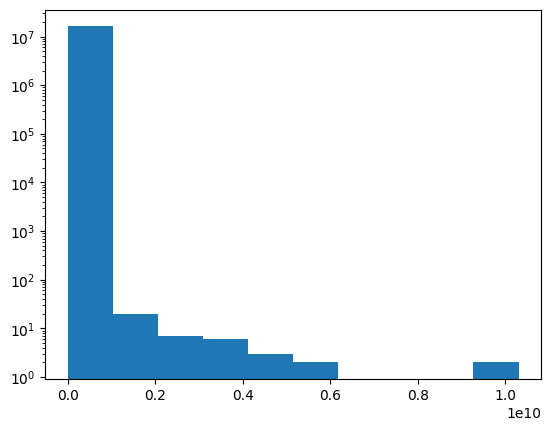

In [41]:
# filter the object by flux
flux_min = 50
full_df = full_df.loc[full_df["flux_r"] > flux_min]
plt.hist(full_df["flux_r"], log=True)
plt.show()

In [ ]:
for k, v in full_df.items():
    if k not in ["is_good_match", "is_nearest_neighbor", "is_unique_truth_entry"]:
        print(f"{k} has {np.isnan(v.values).sum()} nans")

In [ ]:
for k, v in full_df.items():
    if k not in ["is_good_match", "is_nearest_neighbor", "is_unique_truth_entry"]:
        print(f"{k} has {np.isnan(v.values).sum() / len(full_df) * 100:.2f}% nans")

In [ ]:
full_df["flux_r"].describe()

In [ ]:
np.quantile(full_df["flux_r"], q=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99])

In [ ]:
full_df["blendedness"].describe()

In [ ]:
# restrict blendedness
full_df["blendedness"] = np.clip(full_df["blendedness"].values, a_min=0.0, a_max=1.0)

In [ ]:
full_df["blendedness"].describe()

In [ ]:
plt.hist(full_df["blendedness"], log=True)
plt.show()

In [ ]:
blendedness = full_df["blendedness"].values
np.quantile(blendedness[~np.isnan(blendedness)], q=[0.01, 0.03, 0.05, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

In [ ]:
full_df["shear_1"].describe()

In [ ]:
full_df["shear_2"].describe()

In [ ]:
plt.hist(full_df["shear_1"], log=True)
plt.show()

In [ ]:
plt.hist(full_df["shear_2"], log=True)
plt.show()

In [ ]:
full_df["ellipticity_1_true"].describe()

In [ ]:
full_df["ellipticity_2_true"].describe()

In [ ]:
plt.hist(full_df["ellipticity_1_true"], log=True)
plt.show()

In [ ]:
plt.hist(full_df["ellipticity_2_true"], log=True)
plt.show()

In [ ]:
sub_full_df = full_df.sample(10000)
sub_full_df_flux_norm = np.linalg.norm(np.stack([sub_full_df[f"flux_{b}"].values for b in "ugrizy"], axis=0), axis=0)
sub_full_df_cosmodc2_mask = sub_full_df["cosmodc2_mask"]

In [ ]:
plt.scatter(np.log(sub_full_df["flux_r"] + 1), sub_full_df["size_true"])
plt.show()

In [ ]:
plt.scatter(np.log(sub_full_df["flux_r"] + 1), sub_full_df["size_minor_true"])
plt.show()

In [ ]:
plt.scatter(np.log(sub_full_df_flux_norm + 1), sub_full_df["size_true"])
plt.show()

In [ ]:
plt.scatter(np.log(sub_full_df_flux_norm + 1), sub_full_df["size_minor_true"])
plt.show()

In [ ]:
print(np.array2string(np.corrcoef(sub_full_df["size_true"][sub_full_df_cosmodc2_mask], 
                                  np.log(sub_full_df["flux_r"][sub_full_df_cosmodc2_mask] + 1)), precision=3))

In [ ]:
print(np.array2string(np.corrcoef(sub_full_df["size_true"][sub_full_df_cosmodc2_mask], 
                                  np.log(sub_full_df_flux_norm[sub_full_df_cosmodc2_mask] + 1)), precision=3))

In [ ]:
print(np.array2string(np.corrcoef(sub_full_df["size_minor_true"][sub_full_df_cosmodc2_mask], 
                                  np.log(sub_full_df_flux_norm[sub_full_df_cosmodc2_mask] + 1)), precision=3))

In [ ]:
print(np.array2string(np.corrcoef(np.random.randn(sub_full_df_cosmodc2_mask.sum()), 
                                  np.log(sub_full_df_flux_norm[sub_full_df_cosmodc2_mask] + 1)), precision=3))

In [ ]:
sub_full_df_max_size = np.stack([sub_full_df["size_true"].values, 
                                 sub_full_df["size_minor_true"].values], axis=0).max(axis=0)

In [ ]:
plt.scatter(np.log(sub_full_df_flux_norm + 1), sub_full_df_max_size)
plt.show()

In [ ]:
print(np.array2string(np.corrcoef(sub_full_df_max_size[sub_full_df_cosmodc2_mask], 
                                  np.log(sub_full_df_flux_norm[sub_full_df_cosmodc2_mask] + 1)), precision=3))

In [ ]:
plt.scatter(sub_full_df["size_true"], sub_full_df["size_minor_true"])
plt.show()

In [ ]:
sub_full_df_size_sqrt = np.sqrt(sub_full_df["size_true"].values ** 2 + sub_full_df["size_minor_true"].values ** 2)

In [ ]:
plt.scatter(np.log(sub_full_df_flux_norm + 1), sub_full_df_size_sqrt)
plt.show()

In [ ]:
print(np.array2string(np.corrcoef(sub_full_df_size_sqrt[sub_full_df_cosmodc2_mask], 
                                  np.log(sub_full_df_flux_norm[sub_full_df_cosmodc2_mask] + 1)), precision=3))

### Save to File

In [42]:
# create a pickle file 
full_df.to_pickle(output_dir / f"merged_catalog_with_flux_over_{flux_min}.pkl")